# NAMES: Timothy Barao, Marlan McInnes-Taylor
# FSUIDS: tjb13b, mm05f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
class FSA:
    def __init__(self, xt, yt, xv, yv):
        self.load_data(xt, yt, xv, yv)
        
        self.s = 0.001
        self.u = 50 #100
        self.N_iter = 500
        self.lr = 0.0001       #Try 20

        #self.B_0 = 0
 
        self.M = self.x_t.shape[1]
        self.N = self.x_t.shape[0]
        self.B = np.zeros(self.M)
        # self.k = [10, 30, 100, 300, 500]
        
        self.losses = []
    
    
    def load_data(self, x_train_file, y_train_file, x_valid_file, y_valid_file):
        with open(x_train_file) as file:
            
            if "dexter" in x_train_file:
                self.x_t = pd.read_csv(file, delim_whitespace=False, header=None)
            else:    
                self.x_t = pd.read_csv(file, delim_whitespace=True, header=None)
            self.x_t = self.x_t.to_numpy(dtype=np.float64)

        with open(y_train_file) as file:
            self.y_t = pd.read_csv(file, header=None)
            self.y_t = self.y_t.to_numpy(dtype=np.float64)

        with open(x_valid_file) as file:
            
            if "dexter" in x_valid_file:
                self.x_v = pd.read_csv(file, delim_whitespace=False, header=None)
            else:    
                self.x_v = pd.read_csv(file, delim_whitespace=True, header=None)
            self.x_v = self.x_v.to_numpy(dtype=np.float64)
            
        with open(y_valid_file) as file:
            self.y_v = pd.read_csv(file, header=None)
            self.y_v = self.y_v.to_numpy(dtype=np.float64)

        self.N = self.x_t.shape[0]   # Rows
        self.M = self.x_t.shape[1]   # Columns 

        # Standardize data
        for i in range(0, self.M):
            if (not np.any(self.x_v[:, i])):
                self.x_v[:, i].fill(0)
            else:  
                self.x_v[:, i] = (self.x_v[:, i] - np.mean(self.x_v[:, i]))/(np.std(self.x_v[:, i]))

            if(not np.any(self.x_t[:, i])):
                self.x_t[:, i].fill(0)
            else:
                self.x_t[:, i] = (self.x_t[:, i] - np.mean(self.x_t[:, i]))/(np.std(self.x_t[:, i]))  
        
        self.x_v = np.insert(self.x_v, 0, 1, axis=1)
        self.x_t = np.insert(self.x_t, 0, 1, axis=1)

                
    def gradient_update(self):
        loss = self.loss()
        self.B = self.B - self.lr * loss
        return self.B, loss
    
    def loss(self):
    
    
        wx=np.sum(self.x_t*self.B, axis=1)
        ywx=np.sum(wx*self.y_t.flatten())
        
        temp=2.*(ywx-1.)/(1.+(ywx-1.)*(ywx-1.))
        temp=temp*self.y_t.flatten()
        temp[ywx>1.]=0.
        
        grad=np.sum((self.x_t).T*temp, axis=1)+2.*self.s*self.B
        return LA.norm(grad)
 
        #temp = np.sum(self.x_t*self.B, axis=1)
        #temp = np.dot(self.x_t, self.B)
        #temp = np.dot(temp, self.y_t.flatten())
        
        temp = np.matmul(self.x_t, self.B)
        # print((self.y_t.T).shape, temp.shape)
        temp = np.matmul(self.y_t.T, temp)
        temp = LA.norm(temp)
        
        
        if temp > 1:
            temp = 0
        else:
            var = (temp - 1)**2
            temp = np.log(1 + var)
            
        temp += self.s * LA.norm(self.B, 2)        
        temp /= self.N 
        return temp

    
    
    
    
    
        # 0            if x > 1
        # ln(1+(x-1)^2) else
    
    def predict(self):
        xB = np.matmul(self.x_t, self.B)
        yPred = np.sign(xB)
        trainAcc = 1- np.mean(yPred == self.y_t.flatten())
        
        xB = np.matmul(self.x_v, self.B)
        yPred = np.sign(xB)
        testAcc = 1 - np.mean(yPred == self.y_v.flatten())
        return trainAcc, testAcc
    
    def train(self, k):
        mPrev = self.M
        for i in range(0, self.N_iter):
            if k == 30:
                B, loss = self.gradient_update()
                print(loss)
                self.losses.append(loss)
            else:
                self.gradient_update()
            
            temp = (self.N_iter - 2 * i)/(2 * i * self.u + self.N_iter)
            temp = max(0., temp)
            mi = k + (self.M - k) * temp
            mi = int(mi)
            
            if mi < mPrev:
                indc = np.absolute(self.B)
                sort = np.argsort(indc)
                sort = sort[-mi:]
                self.B=self.B[sort]
                self.x_t=(self.x_t.T[sort]).T
                self.x_v=(self.x_v.T[sort]).T
                mPrev = mi
                
            #print("Iteration: ", i, "M_i: ", int(mi))
            #print('Non-zero count: ', np.count_nonzero(self.B))
            
        return 0
    
    
    def print_features(self):
        print("X_train Objs: ", self.x_t.shape[0], "X_train Feats: ", self.x_t.shape[1])
        print("Y_train Objs: ", self.y_t.shape[0])

        print("\nX_valid Objs: ", self.x_v.shape[0], "X_valid Feats: ", self.x_v.shape[1])
        print("Y_valid Objs: ", self.y_v.shape[0])

                
        #self.x_t, self.y_t, self.x_v, self.y_v = x_train, y_train, x_valid, y_valid 


In [3]:
# Select k = [10, 30, 100, 300] features
# Plot the training loss vs iteration number k = 10
# Report in Table the misclassification errors on the training and testing set for models obtained for all k
# Plot the misclassification error on the training set and testing set vs k

In [4]:
K = [10, 30, 100, 300, 500]
trainErrors = []
testErrors = []
losses = []

# Madelon

In [5]:
x_train_file = "../data/MADELON/madelon_train.data"
y_train_file = "../data/MADELON/madelon_train.labels"

x_valid_file = "../data/MADELON/madelon_valid.data"
y_valid_file = "../data/MADELON/madelon_valid.labels"

In [6]:
#model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
#iterations = np.arange(0, model.N_iter)
for k in K:
    #model.print_features()
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    model.train(k)
    if k == 30:
        xVals = np.arange(0, model.N_iter)
        losses = model.losses
    trainAccuracy, testAccuracy = model.predict()
    #print(trainAccuracy, testAccuracy)
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)

1441.7303651035102
352.0771726968309
0.00735242300937892
0.006835352764328945
0.006417771708646666
550.2346151085171
28.244642807460394
49.47177754774738
0.007184158032792793
52.34927859478554
98.99306389481657
67.01610842654938
49.70495773689152
51.065945855185475
0.0068027739090132985
0.006646383890559994
0.0064862222518564
0.006345724815705089
404.01099194432845
91.38152137945747
628.3200385962074
105.54457120547124
0.008403327625157438
70.69315091856443
25.01852942105743
24.349352070360784
23.222705535110922
0.008144297185935071
0.008018686552046536
0.007933845803750733
0.007848087114707747
0.007761380065916425
0.007673692519414369
0.00758499047913102
0.007495237936914888
0.007449962649996337
0.007358561930233722
0.007312439371781264
0.007219296307472432
0.007172277147790908
0.007124947289813856
0.00702931825128114
0.006981018142293091
0.006932381104170512
0.0068833999977485965
0.006834067427955921
0.006784375730784947
0.006734316959396996
0.006683882869290316
0.0066330649024529025

0.006803549007136281
0.006803556460050805
0.006803563912973496
0.00680357136590435
0.006803578818843367
0.006803586271790549
0.0068035937247458945
0.0068036011777094065
0.006803608630681081
0.006803616083660921
0.006803623536648923
0.006803630989645091
0.006803638442649421
0.00680364589566192
0.006803653348682578
0.006803660801711407
0.006803668254748394
0.006803675707793546
0.006803683160846865
0.006803690613908348
0.0068036980669779965
0.006803705520055808
0.0068037129731417815
0.006803720426235923
0.006803727879338228
0.006803735332448695
0.0068037427855673314
0.006803750238694129
0.006803757691829094
0.006803765144972219
0.006803772598123511
0.006803780051282967
0.006803787504450589
0.006803794957626373
0.006803802410810323
0.006803809864002438
0.0068038173172027165
0.00680382477041116
0.006803832223627768
0.006803839676852541
0.006803847130085478
0.0068038545833265796
0.006803862036575845
0.006803869489833279
0.006803876943098875
0.006803884396372633
0.006803891849654559
0.0068038

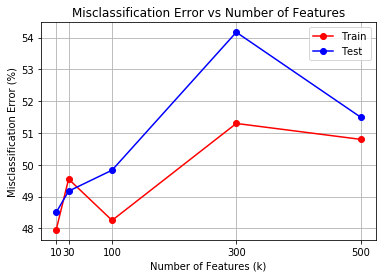

In [7]:
plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(K)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()


In [ ]:

#print(xVals)
plt.plot(xVals, losses, linestyle='-', marker='o', color='g')
plt.grid(True)
#plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [9]:
errorTableMadelon = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableMadelon.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableMadelon.loc[k, 'Training Error (%)'] = trainErr
    errorTableMadelon.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

,Training Error (%),Test Error (%)
N Features,,
10,47.95,48.50
30,49.55,49.17
100,48.25,49.83
300,51.30,54.17
500,50.80,51.50


In [10]:
trainErrors.clear()
testErrors.clear()

# Dexter

In [11]:
x_train_file = "../data/dexter/dexter_train.csv"
y_train_file = "../data/dexter/dexter_train.labels"

x_valid_file = "../data/dexter/dexter_valid.csv"
y_valid_file = "../data/dexter/dexter_valid.labels"

In [ ]:
#model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
#iterations = np.arange(0, model.N_iter)
for k in K:
    #model.print_features()
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    xVals = np.arange(0, model.N_iter)
    model.train(k)
    trainAccuracy, testAccuracy = model.predict()
    #print(trainAccuracy, testAccuracy)
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)

In [ ]:
plt.plot(xVals, model.losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableDexter = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableDexter.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableDexter.loc[k, 'Training Error (%)'] = trainErr
    errorTableDexter.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

In [ ]:
trainErrors.clear()
testErrors.clear()

# Gisette 

In [ ]:
x_train_file = "../data/Gisette/gisette_train.data"
y_train_file = "../data/Gisette/gisette_train.labels"

x_valid_file = "../data/Gisette/gisette_valid.data"
y_valid_file = "../data/Gisette/gisette_valid.labels"

In [ ]:
#model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
#iterations = np.arange(0, model.N_iter)
for k in K:
    #model.print_features()
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    xVals = np.arange(0, model.N_iter)
    model.train(k)
    trainAccuracy, testAccuracy = model.predict()
    #print(trainAccuracy, testAccuracy)
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)

In [ ]:
plt.plot(xVals, model.losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(k, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(k, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableGisette = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableGisette.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableGisette.loc[k, 'Training Error (%)'] = trainErr
    errorTableGisette.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

# Commented Code


In [ ]:
# In Load Data:    
    # x_valid = np.insert(x_valid, 0, 1, axis=1)
    # x_train = np.insert(x_train, 0, 1, axis=1)

    #y_valid = np.where(y_valid == -1, 0, y_valid)  
    #y_train = np.where(y_train == -1, 0, y_train)
    
                '''
                while np.count_nonzero(self.B) > mi:
                    minimum = np.amin(self.B, where=np.where(self.B != 0))
                    indices = np.where(self.B == minimum)
                    for index in indices:
                        self.B[index] = 0
                        if np.count_nonzero(self.B) == mi:
                            break    
                mPrev = mi
            '''